In [1]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')

# for saving
import os

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

from src import setup
# setup.use_gpu()

In [2]:
from src import ( 
    measurements as measure,
    density_matrix as DM,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    simulation)
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '../..')
import h5py
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from src import ket as ket
from src import density_matrix as DM

16


/Users/unnatiakhouri/Documents/GitHub/QuNet/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


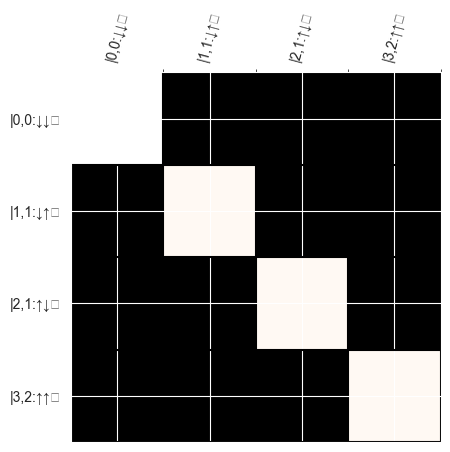

In [3]:
from Scripts import simulation_CLI as cleo
identity = DM.Identity(DM.energy_basis(4))

In [4]:
def get_pops(data, n_qubits, connectivity,update_rule):
    #dimension 0 is each trial
    #dimension 1 is each time step
    #dimension 2 is each qubit
    result = []
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['pops'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        dat = np.array([np.array([dat[k][subkey][()] for subkey in sorted(dat[k])]) for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

def get_2_qbit_dms(data, n_qubits, connectivity,update_rule):
    basis = ket.canonical_basis(2)
    #dimension 0 is each trial
    #dimension 1 is each time step (recall that sampling step is 5 by default)
    #dimension 2 is qubit pair
    #dimension 3 and 4 is the 2 qubit density matrix
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)

    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['two_qubit_dms'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        
        dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

In [7]:
size=8
newdata_random = dict(h5py.File("../../data/random_twentyfive_trials/random_twentyfive_trials.hdf5"))
twoQdmsrandom = get_2_qbit_dms(newdata_random,size,"c2_2local","random")

newdata_mimic = dict(h5py.File("../../data/mimic_twentyfive_trials/mimic_twentyfive_trials.hdf5"))
twoQdmsmimic = get_2_qbit_dms(newdata_mimic,size,"c2_2local","mimic")

In [8]:
for sim_index in twoQdmsmimic:
  # Loop through each time_step in the sim_index
    for time_step in sim_index:
        concurrence = measure.concurrence_of_every_pair_dict(time_step)
    print(concurrence)

{(0, 1): np.complex64(-0.22584659+0j), (0, 2): np.complex64(-0.4407895+0j), (0, 3): np.complex64(-0.09534955+0j), (0, 4): np.complex64(-0.30975416+0j), (0, 5): np.complex64(-0.3944053+0j), (0, 6): np.complex64(-0.27864134+0j), (0, 7): np.complex64(-0.059290588+0j), (1, 2): np.complex64(-0.44297996+0j), (1, 3): np.complex64(-0.08893771+0j), (1, 4): np.complex64(-0.52429396+0j), (1, 5): np.complex64(-0.21013339+0j), (1, 6): np.complex64(-0.35708192+0j), (1, 7): np.complex64(-0.16128811+0j), (2, 3): np.complex64(-0.37112957+0j), (2, 4): np.complex64(-0.35212085+0j), (2, 5): np.complex64(-0.07395768+0j), (2, 6): np.complex64(-0.21614093+0j), (2, 7): np.complex64(-0.19265008+0j), (3, 4): np.complex64(-0.24152267+0j), (3, 5): np.complex64(-0.2453585+0j), (3, 6): np.complex64(-0.13159618+0j), (3, 7): np.complex64(-0.5806476+0j), (4, 5): np.complex64(-0.18106286+0j), (4, 6): np.complex64(-0.24367523+0j), (4, 7): np.complex64(-0.031860277+0j), (5, 6): np.complex64(-0.22115932+0j), (5, 7): np.co

/Users/unnatiakhouri/Documents/GitHub/QuNet/.venv/lib/python3.10/site-packages/matplotlib/colors.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  xa = xa.astype(int)
/Users/unnatiakhouri/Documents/GitHub/QuNet/.venv/lib/python3.10/site-packages/networkx/convert_matrix.py:1116: ComplexWarning: Casting complex values to real discards the imaginary part
  A[i, j] = wts
/Users/unnatiakhouri/Documents/GitHub/QuNet/.venv/lib/python3.10/site-packages/networkx/convert_matrix.py:1118: ComplexWarning: Casting complex values to real discards the imaginary part
  A[j, i] = wts


TypeError: '<' not supported between instances of 'complex' and 'complex'

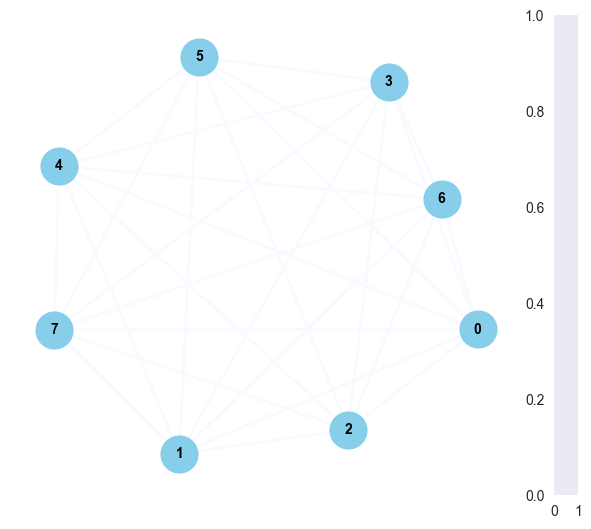

In [9]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Loop through each sim_index
for sim_index in twoQdmsmimic:
    # Create an empty list to store networks for this sim_index
    networks = []
    
    # Loop through each time_step in the sim_index
    for time_step in sim_index:
        concurrence = measure.concurrence_of_every_pair_dict(time_step)
    
        # Create a graph object
        G = nx.Graph()
        
        # Add edges from the dictionary
        for edge, weight in concurrence.items():
            G.add_edge(*edge, weight=weight)
        
        # Normalize edge weights
        edge_weights = [weight for _, _, weight in G.edges(data='weight')]
        norm = Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
        
        # Create a colormap for edge colors
        cmap = plt.cm.Blues
        
        # Add edges with normalized weights and colored edges
        for u, v, data in G.edges(data=True):
            norm_weight = norm(data['weight'])
            G[u][v]['norm_weight'] = norm_weight
            G[u][v]['color'] = cmap(norm_weight)
        
        # Append the graph to the list of networks for this sim_index
        networks.append(G)
    
    # Now plot all networks for this sim_index
    for i, G in enumerate(networks):
        # Draw the graph
        pos = nx.spring_layout(G)  # Positions for all nodes
        nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_weight='bold',
                edge_color=[data['color'] for _, _, data in G.edges(data=True)], width=2.0)
        
        # Create a ScalarMappable for colormap and normalize
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=plt.gca())  # Use current axis (gca)
        cbar.set_label('Edge Weight')
        
        plt.title(f"Graph from Greedy Dictionary with Normalized Edge Weights (Time Step {i})")
        plt.show()

In [11]:
# Initialize an empty 2D array to store mean and std
mean_std_array = []

# Loop through each sim_index
for sim_index in twoQdmsrandom:
    # Create an empty list to store mean and std for this sim_index
    sim_mean_std = []
    
    # Loop through each time_step in the sim_index
    for time_step in sim_index:
        mutual_information_random = measure.mutual_information_of_every_pair_dict(time_step)
        # declaring an empty list
        listr = []
        # appending all the values in the list
        for value in mutual_information_random.values():
            listr.append(value)
        # calculating standard deviation using np.std
        std = np.std(listr)*100
        mean = np.mean(listr)
        
        # Append mean and std to the list for this time step
        sim_mean_std.append([mean, std])
    
    # Append the list for this sim_index to the 2D array
    mean_std_array.append(sim_mean_std)

# Convert the list of lists to a numpy array
mean_std_array = np.array(mean_std_array)

# Print the array
#print(mean_std_array[0])

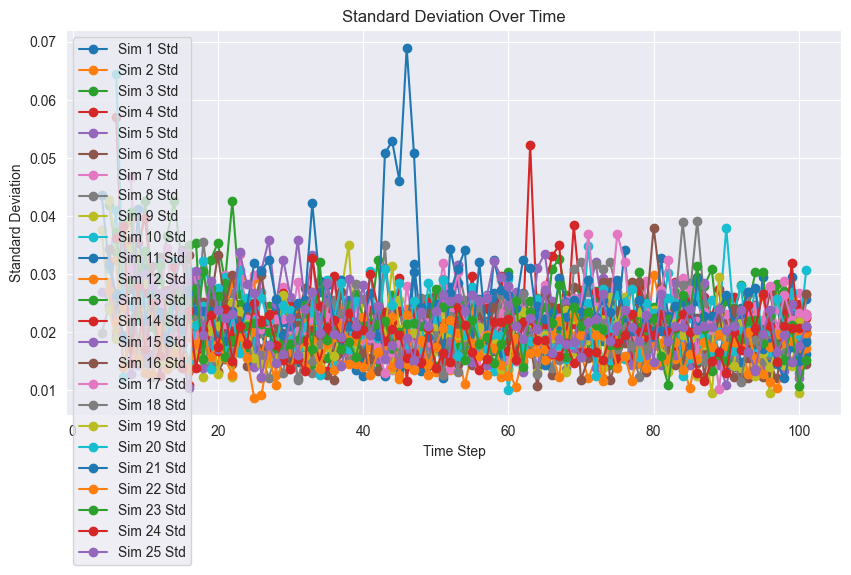

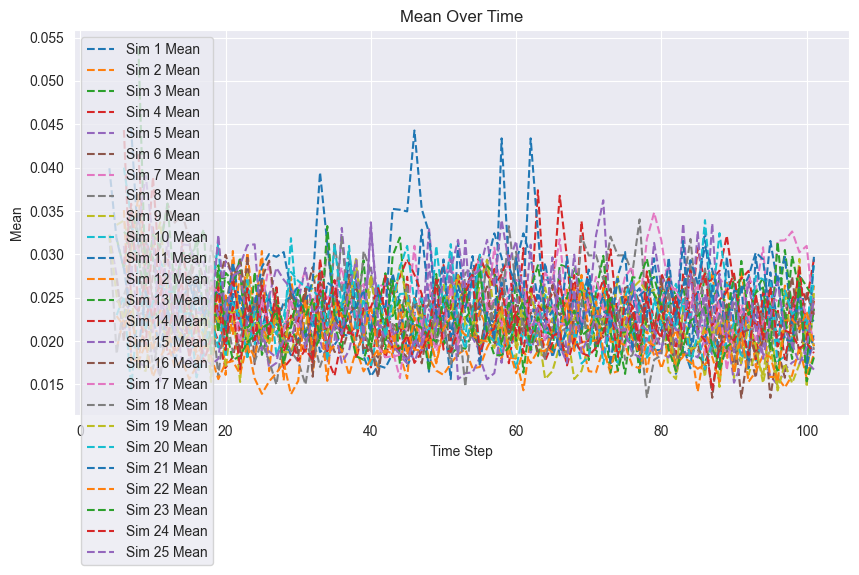

In [24]:
# Initialize an empty 2D array to store mean and std
mean_std_array = []

# Loop through each sim_index
for sim_index in twoQdmsrandom:
    # Create an empty list to store mean and std for this sim_index
    sim_mean_std = []
    
    # Loop through each time_step in the sim_index
    for time_step in sim_index:
        mutual_information_random = measure.mutual_information_of_every_pair_dict(time_step)
        # declaring an empty list
        listr = []
        # appending all the values in the list
        for value in mutual_information_random.values():
            listr.append(value)
        # calculating standard deviation using np.std
        std = np.std(listr)
        mean = np.mean(listr)
        
        # Append mean and std to the list for this time step
        sim_mean_std.append([mean, std])
    
    # Append the list for this sim_index to the 2D array
    mean_std_array.append(sim_mean_std)

# Convert the list of lists to a numpy array
mean_std_array = np.array(mean_std_array)

# Extract standard deviation and mean values for each simulation
stds_random = mean_std_array[:, :, 1]
means_random = mean_std_array[:, :, 0]

# Create x-axis values (time steps)
time_steps = np.arange(1, stds_random.shape[1] + 1)

# Plot standard deviation for each simulation
plt.figure(figsize=(10, 5))
for sim_idx in range(len(stds_random)):
    plt.plot(time_steps, stds_random[sim_idx], '-o', label=f'Sim {sim_idx + 1} Std')

plt.xlabel('Time Step')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot mean for each simulation
plt.figure(figsize=(10, 5))
for sim_idx in range(len(means_random)):
    plt.plot(time_steps, means_random[sim_idx], '--', label=f'Sim {sim_idx + 1} Mean')

plt.xlabel('Time Step')
plt.ylabel('Mean')
plt.title('Mean Over Time')
plt.legend()
plt.grid(True)
plt.show()


/Users/unnatiakhouri/Documents/GitHub/QuNet/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/unnatiakhouri/Documents/GitHub/QuNet/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


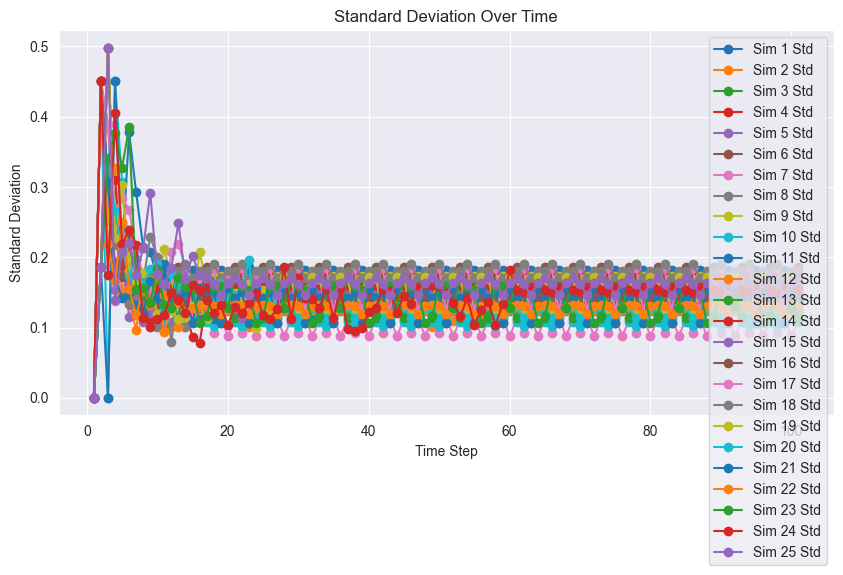

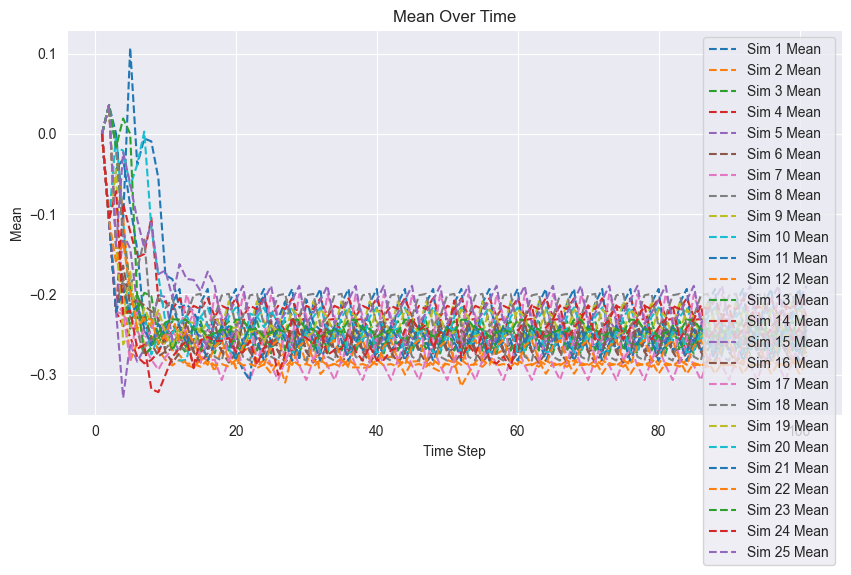

In [26]:
# Initialize an empty 2D array to store mean and std
mean_std_array = []

# Loop through each sim_index
for sim_index in twoQdmsmimic:
    # Create an empty list to store mean and std for this sim_index
    sim_mean_std = []

    # Loop through each time_step in the sim_index
    for time_step in sim_index:
        #measure.concurrence_of_every_pair_dict(time_step)
        mutual_information = measure.mutual_information_of_every_pair_dict(time_step)
        # declaring an empty list
        listr = []
        # appending all the values in the list
        for value in mutual_information.values():
            listr.append(value)
        # calculating standard deviation using np.std
        std = np.std(listr)
        mean = np.mean(listr)
        
        # Append mean and std to the list for this time step
        sim_mean_std.append([mean, std])
    
    # Append the list for this sim_index to the 2D array
    mean_std_array.append(sim_mean_std)

# Convert the list of lists to a numpy array
mean_std_array = np.array(mean_std_array)

# Extract standard deviation and mean values for each simulation
stds_mimic = mean_std_array[:, :, 1]
means_mimic = mean_std_array[:, :, 0]

# Create x-axis values (time steps)
time_steps = np.arange(1, stds_mimic.shape[1] + 1)

# Plot standard deviation for each simulation
plt.figure(figsize=(10, 5))
for sim_idx in range(len(stds_mimic)):
    plt.plot(time_steps, stds_mimic[sim_idx], '-o', label=f'Sim {sim_idx + 1} Std')

plt.xlabel('Time Step')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot mean for each simulation
plt.figure(figsize=(10, 5))
for sim_idx in range(len(means_mimic)):
    plt.plot(time_steps, means_mimic[sim_idx], '--', label=f'Sim {sim_idx + 1} Mean')

plt.xlabel('Time Step')
plt.ylabel('Mean')
plt.title('Mean Over Time')
plt.legend()
plt.grid(True)
plt.show()

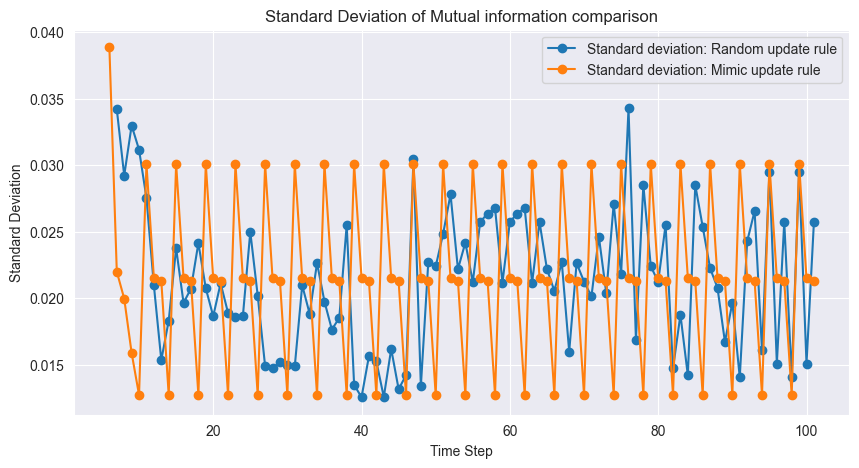

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Example data for stds1 and stds2 (replace these with your actual data)
time_steps = np.arange(1, 102)
stds1 =stds_random[0]
stds2 = stds_mimic[0]

# Plot stds1 and stds2 on the same plot
plt.figure(figsize=(10, 5))
plt.plot(time_steps, stds1, '-o', label='Standard deviation: Random update rule')
plt.plot(time_steps, stds2, '-o', label='Standard deviation: Mimic update rule')
plt.xlabel('Time Step')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Mutual information comparison')
plt.legend()
plt.grid(True)
filename = f"SD_different_update_rules.png"
plt.savefig(filename)
plt.show()



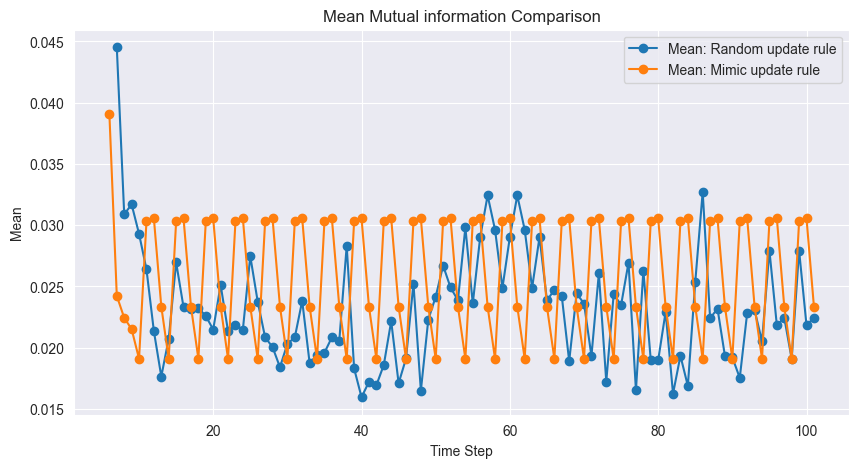

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Example data for stds1 and stds2 (replace these with your actual data)
time_steps = np.arange(1, 102)
means1 = means_random[0]
means2 = means_mimic[0]

# Plot stds1 and stds2 on the same plot
plt.figure(figsize=(10, 5))
plt.plot(time_steps, means1, '-o', label='Mean: Random update rule')
plt.plot(time_steps, means2, '-o', label='Mean: Mimic update rule')
plt.xlabel('Time Step')
plt.ylabel('Mean')
plt.title('Mean Mutual information Comparison')
plt.legend()
plt.grid(True)
# Save the figure with filename indicating time_step and sim_index
filename = f"MI_different_update_rules.png"
plt.savefig(filename)
plt.show()

In [ ]:
measure.co